In [1]:
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_metric
import evaluate

from scripts.tools import load_pickle

import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_PATH = Path('../data/')
random_seed = 54

In [2]:
origin_text = load_pickle(DATA_PATH / "language_sdk.pkl")
preprocessed_text = []
for idx in origin_text:
    language_feats = origin_text[idx]['context_sentences'] + \
        [origin_text[idx]['punchline_sentence']]
    language_feats = list(
        map(lambda i: ' ' + language_feats[i], range(0, len(language_feats))))
    language_feats = '.'.join(language_feats)
    preprocessed_text.append(language_feats[1::])

target_dict = load_pickle(DATA_PATH / "humor_label_sdk.pkl")
target = list(target_dict.values())

hug_dataset = Dataset.from_dict({'text' : preprocessed_text, 'label': target})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(sample):
    return tokenizer(sample["text"], padding=True, truncation=True)

tokenized_datasets = hug_dataset.map(tokenize_function, batched=True)

dataset = tokenized_datasets.train_test_split(test_size=0.3, seed=random_seed)

Map:   0%|          | 0/10166 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7116
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3050
    })
})

In [5]:
dataset.save_to_disk("../data/tokenized_text_ds")

Saving the dataset (0/1 shards):   0%|          | 0/7116 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3050 [00:00<?, ? examples/s]

In [6]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "NONHUMOR", 1: "HUMOR"}
label2id = {"NONHUMOR": 0, "HUMOR": 1}

In [7]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=2, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="../models/text_roberta_train",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

  0%|          | 0/4450 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.677, 'learning_rate': 1.7752808988764045e-05, 'epoch': 0.56}


  0%|          | 0/191 [00:00<?, ?it/s]

{'eval_loss': 0.603458046913147, 'eval_accuracy': 0.7137704918032787, 'eval_runtime': 34.5465, 'eval_samples_per_second': 88.287, 'eval_steps_per_second': 5.529, 'epoch': 1.0}
{'loss': 0.5764, 'learning_rate': 1.5505617977528093e-05, 'epoch': 1.12}
{'loss': 0.5096, 'learning_rate': 1.3258426966292135e-05, 'epoch': 1.69}


  0%|          | 0/191 [00:00<?, ?it/s]

{'eval_loss': 0.6859983205795288, 'eval_accuracy': 0.6950819672131148, 'eval_runtime': 123.0709, 'eval_samples_per_second': 24.782, 'eval_steps_per_second': 1.552, 'epoch': 2.0}
{'loss': 0.4208, 'learning_rate': 1.101123595505618e-05, 'epoch': 2.25}
{'loss': 0.4042, 'learning_rate': 8.764044943820226e-06, 'epoch': 2.81}


  0%|          | 0/191 [00:00<?, ?it/s]

{'eval_loss': 0.6867533922195435, 'eval_accuracy': 0.7180327868852459, 'eval_runtime': 115.7802, 'eval_samples_per_second': 26.343, 'eval_steps_per_second': 1.65, 'epoch': 3.0}
{'loss': 0.3079, 'learning_rate': 6.51685393258427e-06, 'epoch': 3.37}
{'loss': 0.2707, 'learning_rate': 4.269662921348315e-06, 'epoch': 3.93}


  0%|          | 0/191 [00:00<?, ?it/s]

{'eval_loss': 1.2281357049942017, 'eval_accuracy': 0.7245901639344262, 'eval_runtime': 62.856, 'eval_samples_per_second': 48.524, 'eval_steps_per_second': 3.039, 'epoch': 4.0}
{'loss': 0.1868, 'learning_rate': 2.02247191011236e-06, 'epoch': 4.49}


  0%|          | 0/191 [00:00<?, ?it/s]

{'eval_loss': 1.3986605405807495, 'eval_accuracy': 0.72, 'eval_runtime': 124.6546, 'eval_samples_per_second': 24.468, 'eval_steps_per_second': 1.532, 'epoch': 5.0}
{'train_runtime': 2740.0924, 'train_samples_per_second': 12.985, 'train_steps_per_second': 1.624, 'train_loss': 0.3965918620248859, 'epoch': 5.0}


TrainOutput(global_step=4450, training_loss=0.3965918620248859, metrics={'train_runtime': 2740.0924, 'train_samples_per_second': 12.985, 'train_steps_per_second': 1.624, 'train_loss': 0.3965918620248859, 'epoch': 5.0})

In [10]:
predicts = trainer.predict(dataset['test'])

  0%|          | 0/191 [00:00<?, ?it/s]

In [48]:
predicts

PredictionOutput(predictions=array([[-0.5658703 ,  0.5864019 ],
       [-0.54844016,  0.59570825],
       [ 0.92058486, -1.3433995 ],
       ...,
       [ 0.9962201 , -1.3151264 ],
       [-0.5779434 ,  0.6401772 ],
       [ 0.2349451 , -0.40068248]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 1, 1], dtype=int64), metrics={'test_loss': 0.603458046913147, 'test_accuracy': 0.7137704918032787, 'test_runtime': 204.0085, 'test_samples_per_second': 14.95, 'test_steps_per_second': 0.936})

In [23]:
labels = predicts[1]

In [25]:
predicted_probs = torch.softmax(torch.tensor(predicts[0]), -1)
predicted_classes = torch.argmax(predicted_probs, -1)

Accuracy: 0.7137704918032787

Precision: 0.705632949727438

Recall: 0.7506443298969072



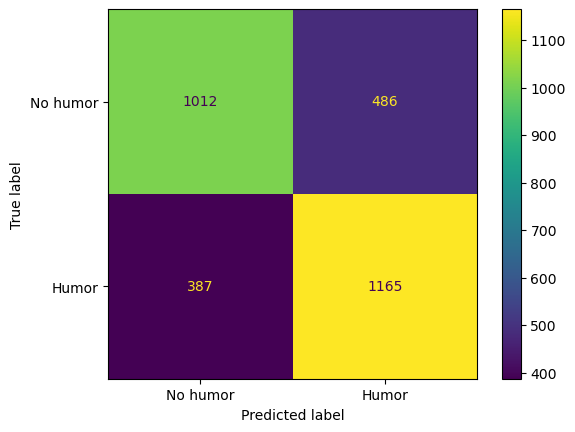

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

print(f"Accuracy: {accuracy_score(labels, predicted_classes)}\n")
print(f"Precision: {precision_score(labels, predicted_classes)}\n")
print(f"Recall: {recall_score(labels, predicted_classes)}\n")
cnf = confusion_matrix(labels, predicted_classes)
cnf_disp = ConfusionMatrixDisplay(confusion_matrix=cnf, display_labels=['No humor', 'Humor'])
cnf_disp.plot()

In [42]:
predicted_probs

tensor([[0.2401, 0.7599],
        [0.2416, 0.7584],
        [0.9059, 0.0942],
        ...,
        [0.9098, 0.0902],
        [0.2283, 0.7717],
        [0.6538, 0.3462]])

In [43]:
torch.save(predicted_probs, 'predicted_probs_text.pt')

In [51]:
model.save_pretrained("../models/text_roberta_train/best_model")